# Miniproject 1
Fingermovements predicting

**///////////// TODO //////////////**

split val_acc og train_acc i 2 figurer med samme farge

bare hvis test_error på siste result
så diskuter crossvalidation and stratified shufflegreier

- continue with LSTM
    - stacked LSTM
    - dropout
    - hidden width 
    - several hidden layers
- last phase
    - prøve "lstm_0.4drop_200e_100hrz" med 110 epochs ettersom det ser bra ut på val_loss...
    - check with different optimizers
    - loss functions
    - activation functions
- fix densemodel so it work without flattening data first...must hardcode the best densenet in the end i think
- remember to set seed and check if reprodusible
- make test.py that trains and plots the comparison of chosen algorihtms

In [3]:
# IMPORTS
import torch
from torch import Tensor, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import numpy as np
from math import log10
import dlc_bci as bci
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

# Our own code
import helpers as HL
import models as ML
from models import *

%reload_ext autoreload
%autoreload 2

### Importing data

In [4]:
train_data, val_data, test_data = HL.import_data(flatten=False, one_khz=False, train_size=270)

Original data format: 
<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
Modified train_data.data_tensor shape:  torch.Size([270, 28, 50])
Modified train_data.target_tensor shape:  torch.Size([270, 2])
val_data.data_tensor shape:  torch.Size([46, 28, 50])


### Create new models if you want

In [5]:
def SenseNet(input_dim, output_dim, nb_hidden_layers=1, hidden_width=100, dropout_rate=False):
    """
    Fully connected feedforward neural net with adjustible, but uniform width of hidden layers and and adjustable depth
    """
    if nb_hidden_layers < 1:
        print("you need at least one hidden layer")
        model = None
    else:
        layers = []
        layers.append(nn.Linear(input_dim, hidden_width))
        layers.append(nn.ReLU())
        for i in range(nb_hidden_layers-1):
            layers.append(nn.Linear(hidden_width, hidden_width))
            layers.append(nn.ReLU())
            if type(dropout_rate) == float and dropout_rate > 0.0 and dropout_rate < 1.0:
                layers.append(nn.Dropout(p=dropout_rate))

        layers.append(nn.Linear(hidden_width, output_dim))
        layers.append(nn.Softmax())

        model = nn.Sequential(*layers)
        return model
    
    
    


class conv_net1(nn.Module):
    def __init__(self, input_dim, hidden_width, nb_layers, output_dim):
        super().__init__()
        # makes 224 features out of the time series and 24 features
        # feature making
        self.conv1 = nn.Conv1d(input_dim, 56, kernel_size=4, stride=4, padding=0)
        self.conv2 = nn.Conv1d(56, 112, kernel_size=3, stride=3, padding=0)
        self.conv3 = nn.Conv1d(112, 224, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv1d(224, 224, kernel_size=2, stride=1, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        #self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc1 = torch.nn.Linear(224, hidden_width)
        self.r = nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_width, output_dim)
        self.smax = torch.nn.Softmax(dim=0)
    
    def forward(self, x):
        # feature making
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        # remove redundant dimension before classification
        out = out.view(out.shape[0],-1)
        
        # classification
        out = self.fc1(out)
        out = self.r(out)
        out = self.fc2(out)
        out = self.smax(out)
        return out

class LSTM_basic_dropout(nn.Module):
    def __init__(self, input_dim, output_dim, recurrent_dim, num_layers=1, dropout_rate=None):
        super().__init__ ()
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = recurrent_dim, num_layers = num_layers, dropout=dropout_rate, batch_first=True)
        self.fc_o2y = nn.Linear(recurrent_dim, output_dim)
        
    def forward (self, input):
        # switch places for sequence and features
        input.transpose_(1,2)
        output, _ = self.lstm(input)
        output = self.fc_o2y(F.relu(output))
        #print("prev_output: ", prev_output.shape)
        #print("prev_output", prev_output)
        #print("F.softmax(prev_output, dim=2)[:,-1,:]  ", F.softmax(prev_output, dim=2)[:,-1,:])
        return F.softmax(output, dim=2)[:,-1,:] # Get the activations of all layers at the last time step


# class LSTM_basic_dropout
# class LSTM_2

### Choose model and define loss criterion and train

In [6]:
# initialize parameters and hyperparameters
input_dim = len(train_data[0][0])
sequence_length = train_data.data_tensor.size()[2]
output_dim = train_data.target_tensor.size(1)
nb_hidden_layers = 3
hidden_width = 500
dropout_rate=0.2

print("input_dim: ", input_dim)
print("output_dim: ", output_dim)

# initialize the models
linear_model = ML.linear_model(input_dim*sequence_length, output_dim)
log_sigmoid_model = ML.logistic_sigmoid_model(input_dim*sequence_length, output_dim)
log_softmax_model = ML.logistic_softmax_model(input_dim*sequence_length, output_dim)
densemodel_1 = ML.DenseNet(input_dim, output_dim, nb_hidden_layers, hidden_width, dropout_rate)

sensemodel = SenseNet(input_dim, output_dim, nb_hidden_layers, hidden_width, dropout_rate)
conv_model1 = conv_net1(input_dim, hidden_width, nb_hidden_layers, output_dim)
lstm_model = ML.LSTM_net(input_dim, dim_recurrent=111, num_layers=1, dim_output=output_dim)
lstm_dropout = LSTM_basic_dropout(input_dim, output_dim, recurrent_dim=111, num_layers=1, dropout_rate=dropout_rate)
lstm_2_dropout = LSTM_basic_dropout(input_dim, output_dim, recurrent_dim=111, num_layers=2, dropout_rate=dropout_rate)

# choosing model
model = lstm_2_dropout

# define loss criterion
criterion = nn.BCELoss()
#criterion = nn.MSELoss() # for linear_model

# choose optimizer
optimizer = torch.optim.Adam # default
#optimizer = torch.optim.SGD

print(model)


input_dim:  28
output_dim:  2
LSTM_basic_dropout(
  (lstm): LSTM(28, 111, num_layers=2, batch_first=True, dropout=0.2)
  (fc_o2y): Linear(in_features=111, out_features=2, bias=True)
)


### Training model

In [42]:
#torch.manual_seed(7)

trained_model, history, parameters = HL.train_model(train_data, val_data, model, criterion, optimizer, learning_rate=1e-3, epochs=200, batch_size=32, checkpoint_name='testingtesting')


Number of trainsamples:  270
Number of valsamples:  46
===> Epoch 0 Complete: Avg. Loss: 0.0230
===> Prediction TRAIN-error: 0.4678
===> Avg. VAL-loss: 0.0303
===> Prediction  VAL-error: 0.5357
Checkpoint: checkpoint_models/testingtesting_epoch_0.pth -------------------------------------


/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type LSTM_basic_dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


===> Epoch 20 Complete: Avg. Loss: 1.0271
===> Prediction TRAIN-error: 0.1424
===> Avg. VAL-loss: 0.4517
===> Prediction  VAL-error: 0.2478
Checkpoint: checkpoint_models/testingtesting_epoch_20.pth -------------------------------------
===> Epoch 40 Complete: Avg. Loss: 0.1388
===> Prediction TRAIN-error: 0.0104
===> Avg. VAL-loss: 0.7896
===> Prediction  VAL-error: 0.3147
Checkpoint: checkpoint_models/testingtesting_epoch_40.pth -------------------------------------
===> Epoch 60 Complete: Avg. Loss: 0.2613
===> Prediction TRAIN-error: 0.0382
===> Avg. VAL-loss: 0.5411
===> Prediction  VAL-error: 0.2902
Checkpoint: checkpoint_models/testingtesting_epoch_60.pth -------------------------------------
===> Epoch 80 Complete: Avg. Loss: 0.1484
===> Prediction TRAIN-error: 0.0312
===> Avg. VAL-loss: 0.9800
===> Prediction  VAL-error: 0.2679
Checkpoint: checkpoint_models/testingtesting_epoch_80.pth -------------------------------------
===> Epoch 100 Complete: Avg. Loss: 0.0615
===> Predicti

### Plotting data from training
- here is NEW model that was just trained benchpressed with other models

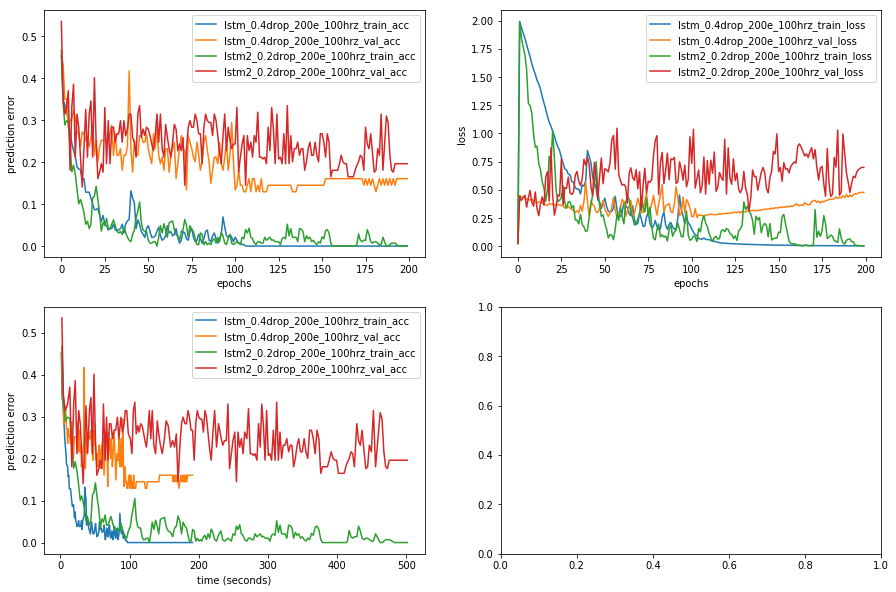

In [8]:
# potential_models: ["lstm_1", "lstm_1_300epochs", "conv_net1", "lstm_1_100e_1000hrz", "linear_2000e_100hrz", 
# "ligsig_2000e_100hrz", "linear_2000e_100hrz"]

# with proper dict: ["ligsmax_200e_100hrz", "ligsig_200e_100hrz", "linear_2000e_100hrz", "lstm_200e_100hrz",
# "lstm_0.4drop_old", "lstm_0.4drop_old", "lstm_0.4drop_200e_100hrz", "lstm_0.6drop_200e_100hrz", 
#"lstm2_0.4drop_200e_100hrz", "lstm2_0.2drop_200e_100hrz"]

HL.plot_model_training(history=None, models=["lstm_0.4drop_200e_100hrz","lstm2_0.2drop_200e_100hrz"]) # "lstm_200e_100hrz"

### Saving model with training data
Just uncomment and run to save recently trained model

In [44]:
HL.pickle_model(trained_model, history, parameters, "lstm2_0.2drop_200e_100hrz")

### Testing models

In [45]:
HL.test_models(train_data, val_data, test_data,
["ligsmax_200e_100hrz", "ligsig_200e_100hrz", "linear_2000e_100hrz", "lstm_200e_100hrz", "lstm_0.1drop_old",
 "lstm_0.4drop_old", "lstm_0.4drop_200e_100hrz", "lstm_0.6drop_200e_100hrz", "lstm2_0.4drop_200e_100hrz",
 "lstm2_0.2drop_200e_100hrz"])


Calculating prediction error on an ensemble of trained models

| Model name:                | Train error:               | Validation error:          | Test error                 
| ligsmax_200e_100hrz        | 0.3149801587301587         | 0.37723214285714285        | 0.4453125                  
| ligsig_200e_100hrz         | 0.25992063492063494        | 0.1763392857142857         | 0.4375                     
| linear_2000e_100hrz        | 0.006944444444444444       | 0.29910714285714285        | 0.4765625                  
| lstm_200e_100hrz           | 0.0                        | 0.23214285714285715        | 0.265625                   
| lstm_0.1drop_old           | 0.053075396825396824       | 0.29910714285714285        | 0.3203125                  
| lstm_0.4drop_old           | 0.017361111111111112       | 0.1763392857142857         | 0.1796875                  
| lstm_0.4drop_200e_100hrz   | 0.0                        | 0.1607142857142857         | 0.1875                     


## If more time would have done:
- spent more time on understanding the underlying eeg-data
- I read about how to make spacial features based on where the electodes are placed on the head.
- data augmentation
- tested gru
- tested temporal convnet with dilution
- earlystopping